## Imports e carregamento do dataset

In [ ]:
#Importando as Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

#Carregando os dados
df = pd.read_excel('dados/online_retail_II.xlsx', sheet_name='Year 2010-2011')

#Verificação inicial
print(df.head())
print(df.info())


  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

## Limpeza dos dados

In [ ]:
#Remoção de nulos
df = df.dropna(subset=['Customer ID', 'InvoiceDate', 'Invoice', 'Quantity', 'Price'])

#Removendo valores negativos ou nulos
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

#Calculando o valor total da compra
df['TotalAmount'] = df['Quantity'] * df['Price']

#Verificando se tem e caso tenha remove as duplicatas
df = df.drop_duplicates()

#Convertendo colunas que contém data para datatime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#Verificando os dados depois da limpeza
print(df.describe())


            Quantity                    InvoiceDate          Price  \
count  392693.000000                         392693  392693.000000   
mean       13.119671  2011-07-10 19:13:41.156272128       3.125952   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492603                            NaN      22.241820   

         Customer ID    TotalAmount  
count  392693.000000  392693.000000  
mean    15287.837224      22.631488  
min     12346.000000       0.001000  
25%     13955.000000       4.950000  
50%     15150.000000      12.450000  
75%     16791.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.542421     311.098828  


## Função para calcular RFM

In [3]:
def calcular_rfm(df, data_col='InvoiceDate', cliente_col='Customer ID', valor_col='TotalAmount', data_base=None):
    if data_base is None:
        data_base = df[data_col].max() + pd.Timedelta(days=1)
    
    rfm = df.groupby(cliente_col).agg({
        data_col: lambda x: (data_base - x.max()).days,
        cliente_col: 'count',
        valor_col: 'sum'
    })
    
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    return rfm

rfm = calcular_rfm(df)
print(rfm.head())


             Recency  Frequency  Monetary
Customer ID                              
12346.0          326          1  77183.60
12347.0            2        182   4310.00
12348.0           75         31   1797.24
12349.0           19         73   1757.55
12350.0          310         17    334.40


## Score RFM (de 1 a 5)

In [4]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


## Heatmap com o Score RFM

C:\Users\Matt\AppData\Local\Temp\ipykernel_8004\2429669491.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_heatmap = rfm.groupby(['R_Score','F_Score']).size().unstack()


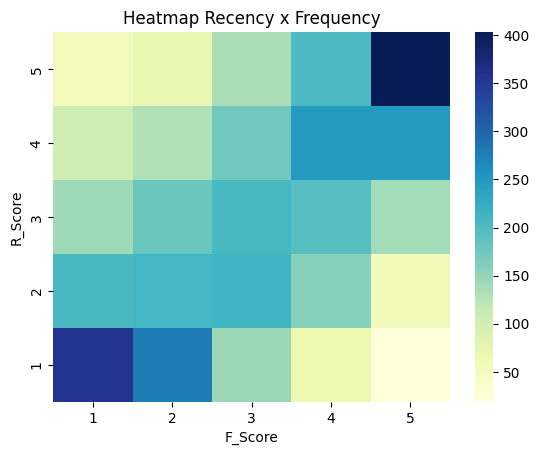

In [5]:
rfm_heatmap = rfm.groupby(['R_Score','F_Score']).size().unstack()
sns.heatmap(rfm_heatmap, cmap="YlGnBu")
plt.title('Heatmap Recency x Frequency')
plt.show()


## Normalização para clustering

In [6]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


## Utilizando o Método Elbow 

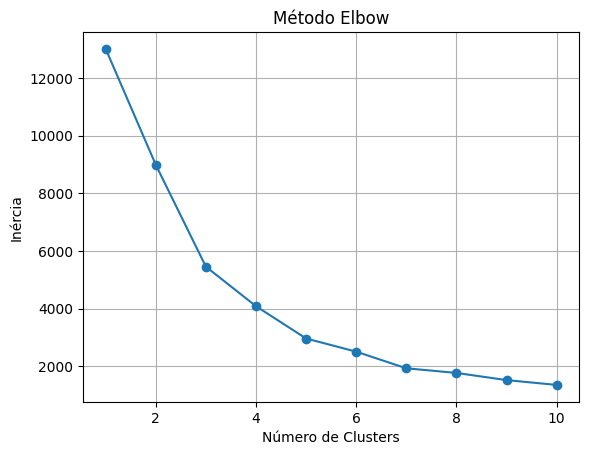

In [7]:
inertia = []
range_n = range(1, 11)
for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

plt.plot(range_n, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método Elbow')
plt.grid()
plt.show()


## Aplicando o K-Means e Silhouette Score

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

sil_score = silhouette_score(rfm_normalized, rfm['Cluster'])
print(f"Silhouette Score: {sil_score:.2f}")


Silhouette Score: 0.61


## Visualização 2D do PCA

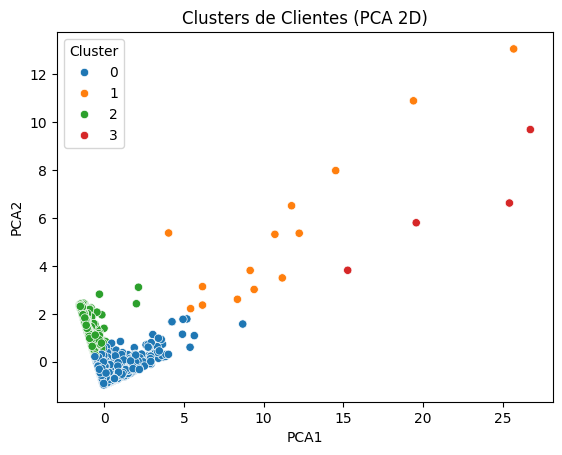

In [9]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_normalized)
rfm['PCA1'], rfm['PCA2'] = pca_result[:,0], pca_result[:,1]

sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("Clusters de Clientes (PCA 2D)")
plt.show()


## Visualização dos Clusters com Boxplots 

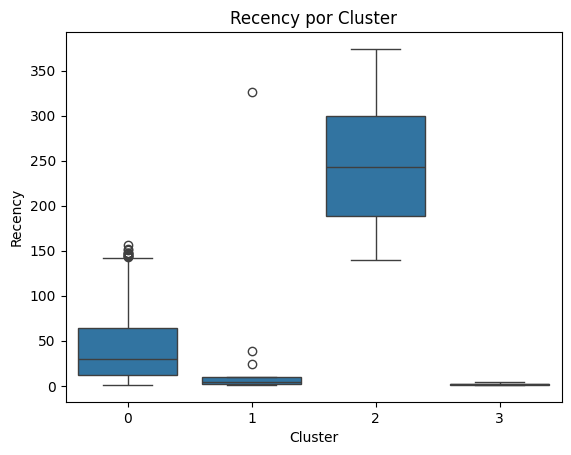

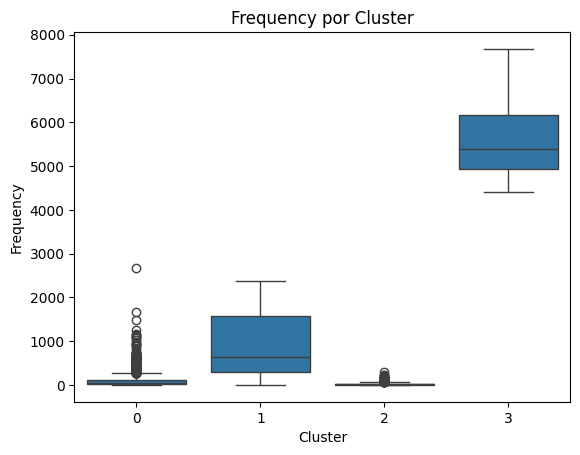

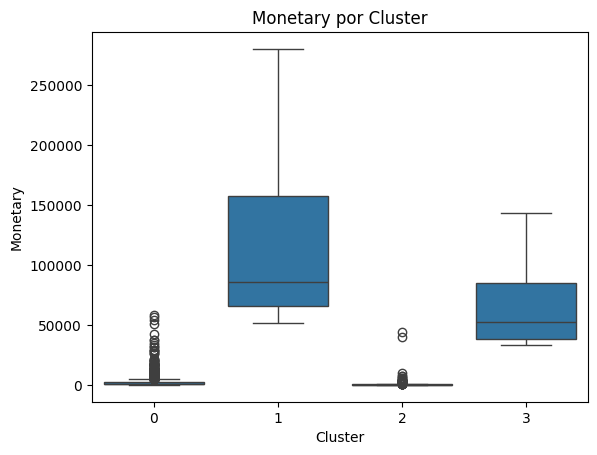

In [10]:
for col in ['Recency', 'Frequency', 'Monetary']:
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f'{col} por Cluster')
    plt.show()


## Importância das Variáveis

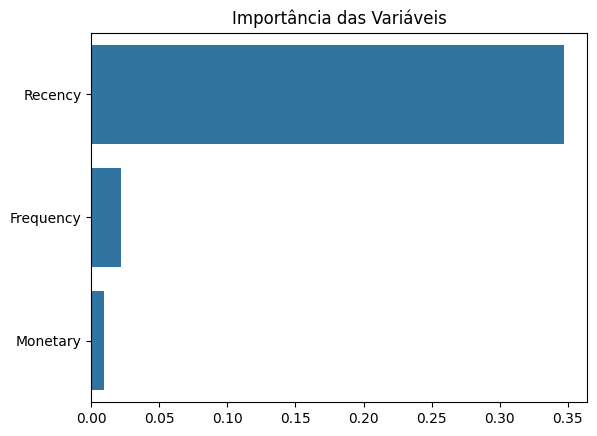

In [11]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(rfm[['Recency','Frequency','Monetary']], rfm['Cluster'])

imp = permutation_importance(tree, rfm[['Recency','Frequency','Monetary']], rfm['Cluster'])
sns.barplot(x=imp.importances_mean, y=['Recency','Frequency','Monetary'])
plt.title("Importância das Variáveis")
plt.show()


## Aplicação de DBSCAN como comparação

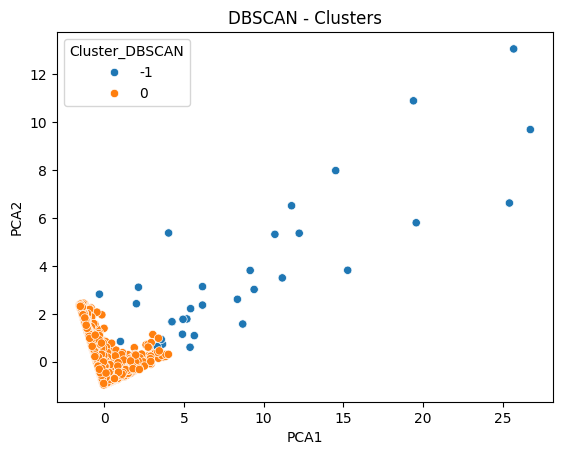

In [12]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_normalized)

sns.scatterplot(data=rfm, x="PCA1", y="PCA2", hue="Cluster_DBSCAN", palette="tab10")
plt.title("DBSCAN - Clusters")
plt.show()


##  Tabela com Detalhes

In [13]:
summary = rfm.groupby("Cluster").agg({
    "Recency": ["mean", "min", "max"],
    "Frequency": ["mean", "min", "max"],
    "Monetary": ["mean", "min", "max"],
    "Cluster": "count"
}).round(2)

summary.columns = ['_'.join(col) for col in summary.columns]
summary.rename(columns={"Cluster_count": "Num_Clientes"}, inplace=True)
display(summary)


,Recency_mean,Recency_min,Recency_max,Frequency_mean,Frequency_min,Frequency_max,Monetary_mean,Monetary_min,Monetary_max,Num_Clientes
Cluster,,,,,,,,,,
0,41.44,1,156,101.01,1,2677,1943.36,6.20,58510.48,3242
1,31.00,1,326,915.86,1,2366,121183.10,51527.30,280206.02,14
2,247.33,140,374,27.39,1,297,563.86,3.75,44534.30,1078
3,2.00,1,4,5717.25,4412,7676,70612.25,33053.19,143711.17,4
